# Intro

## Eagle 127 qubit device

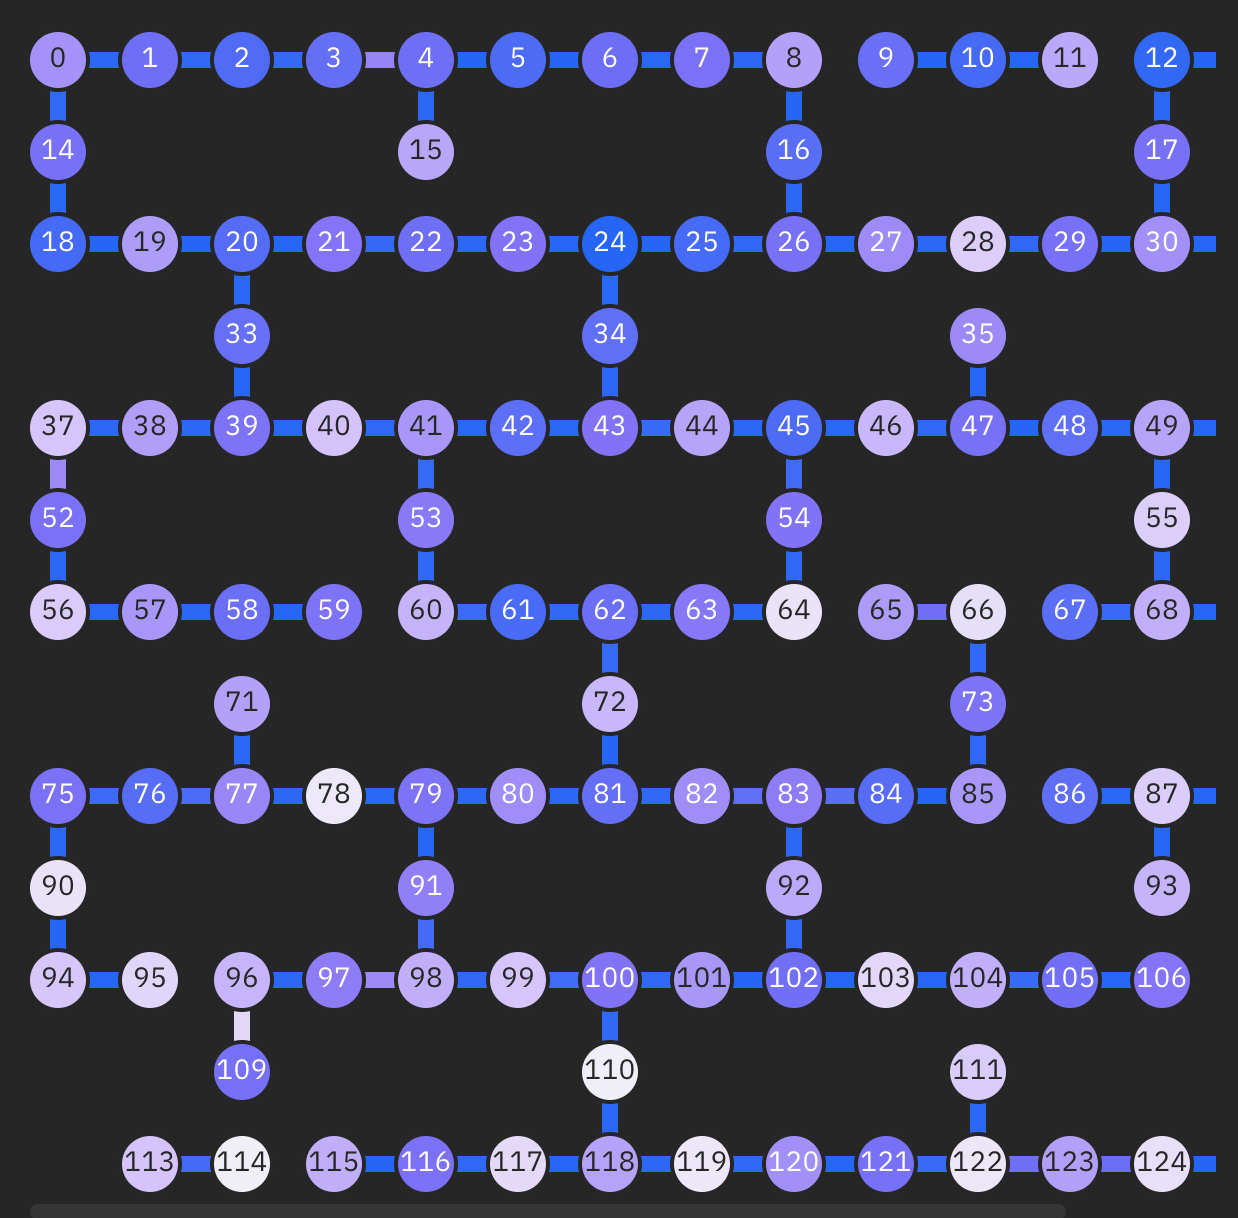

## Abstract Heavy Hex Lattice

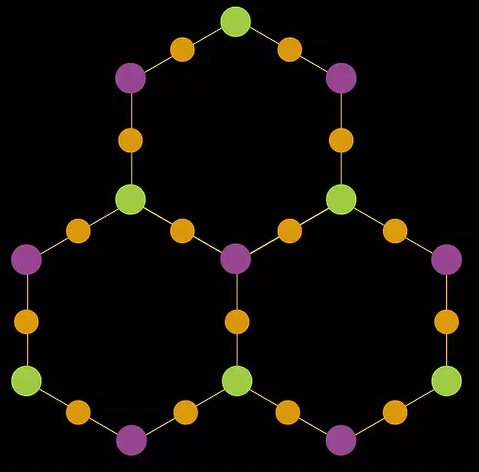

## Reducing Connectivity Avoid Errors

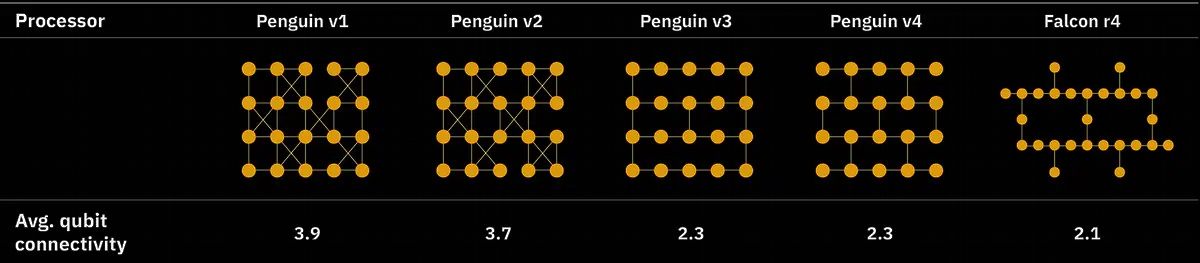

## Admits QEC Code

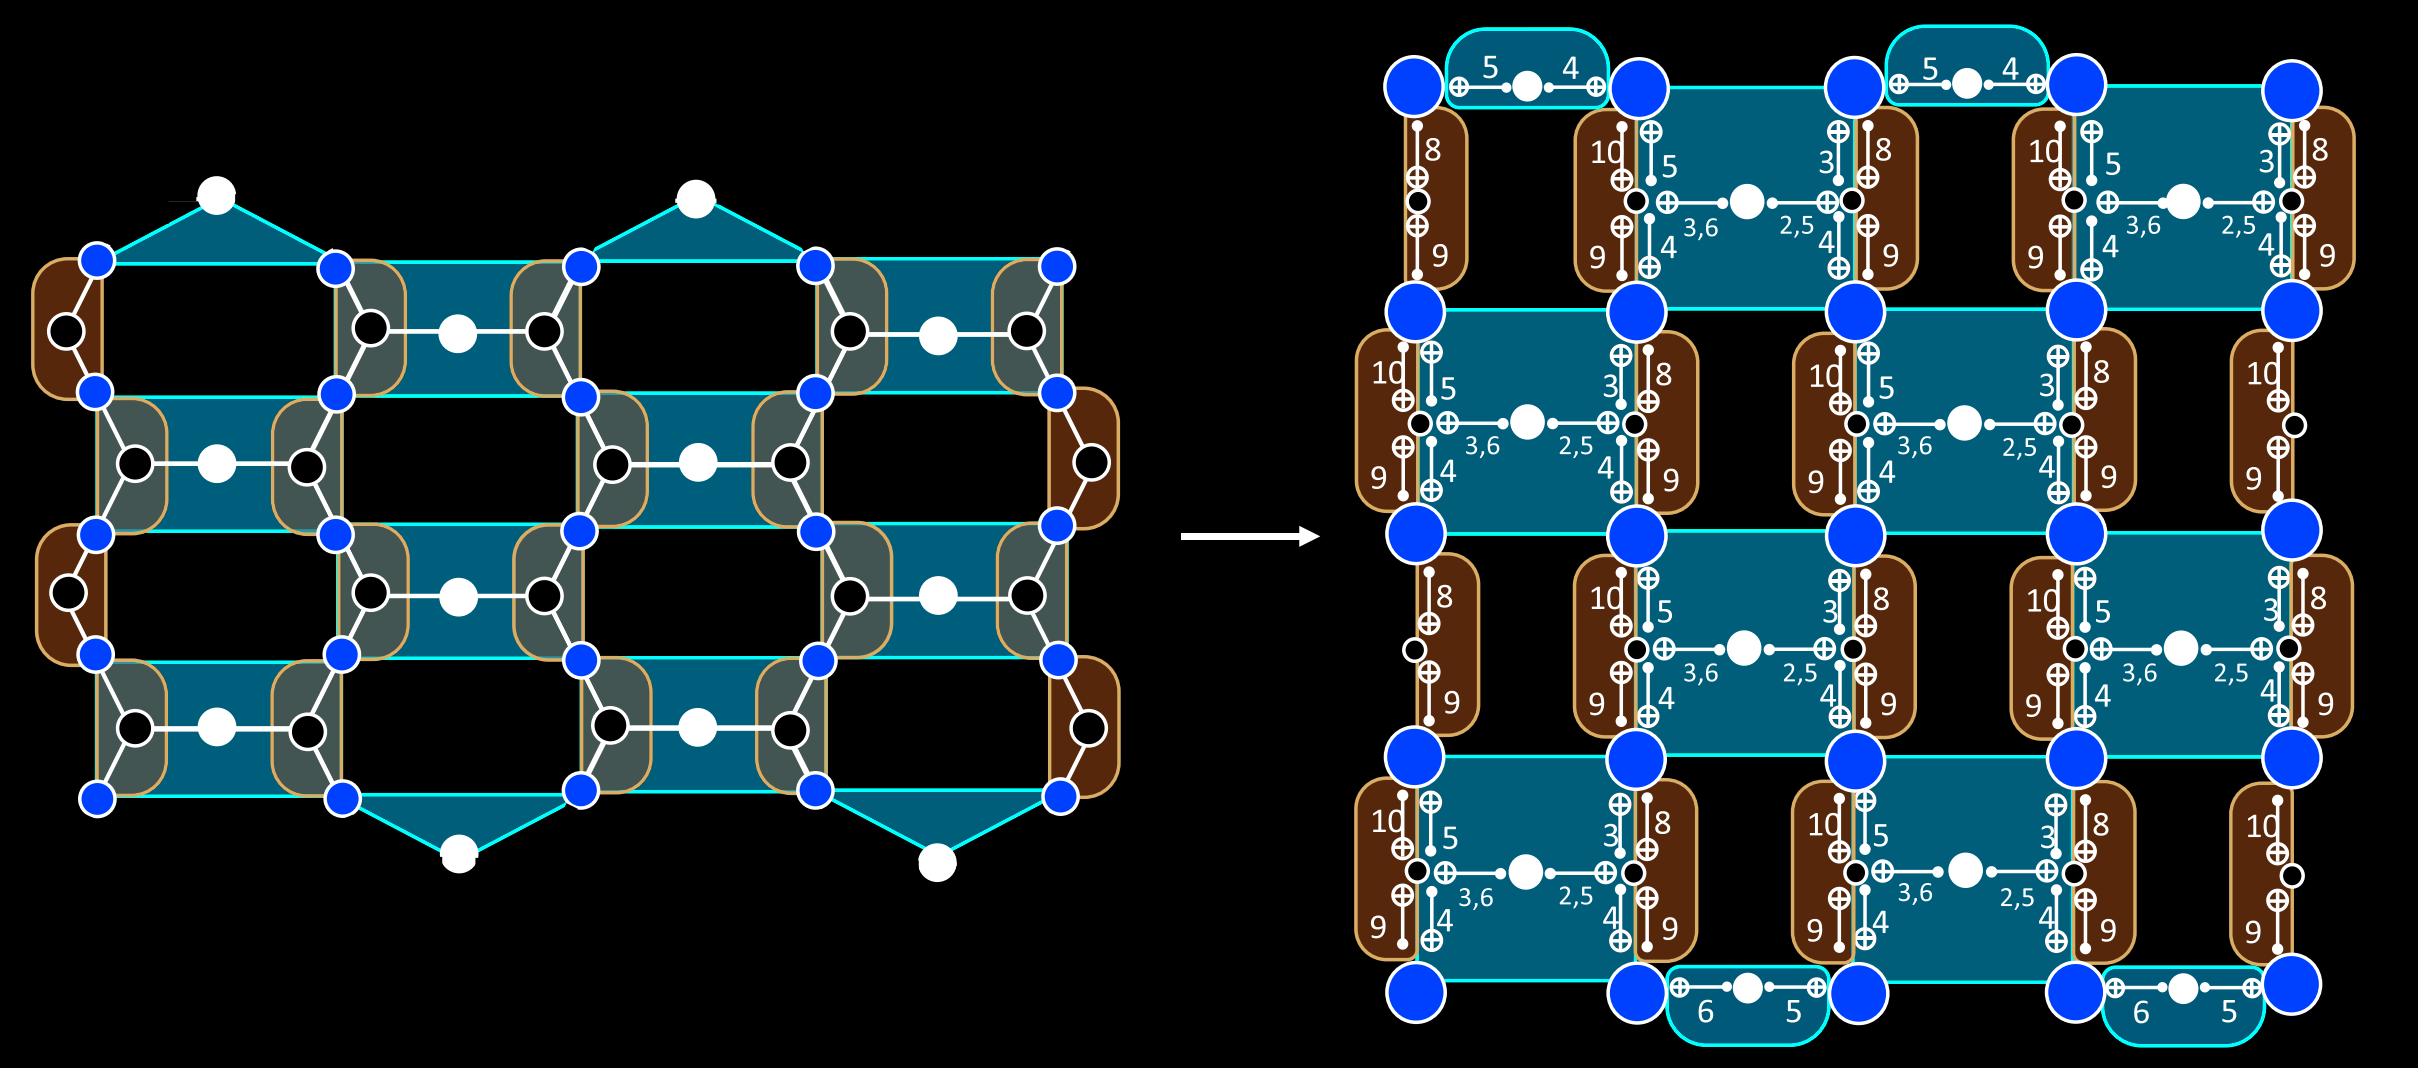

# Building the QEC Circuit in Qiskit

## Import Libraries and Backend

In [1]:
from qiskit import IBMQ, transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_gate_map, plot_circuit_layout, plot_histogram

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeGuadalupe

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [5, 5]
scale_factor = 0.6

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='my_hub', group='my_group', project='my_project')
backend = provider.get_backend('ibmq_guadalupe') # actual quantum backend

## Build X-parity Circuit

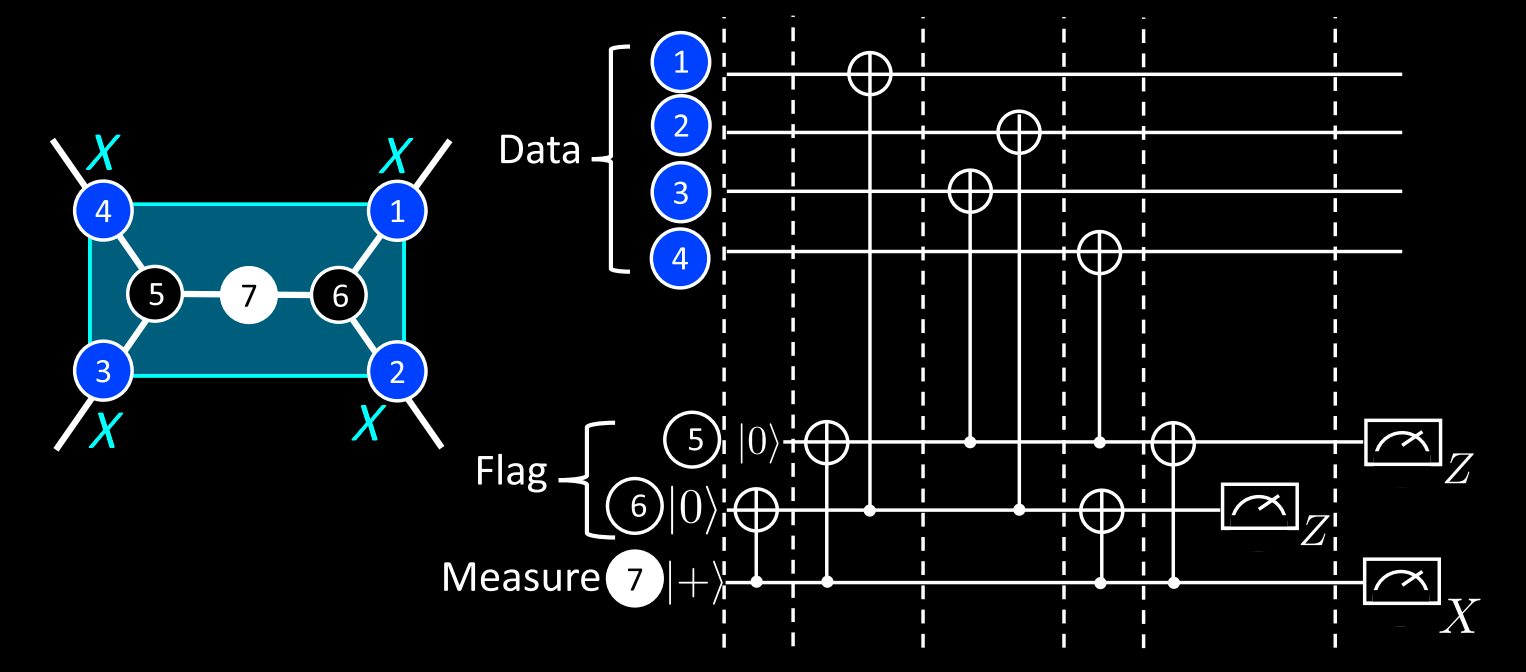

In [3]:
#qreg = QuantumRegister(7, 'q')
#creg = ClassicalRegister(3, 'c')
#qc = QuantumCircuit(qreg, creg)

def check_x(qc, creg):
    qc.reset([4, 5, 6])
    qc.h(6)
    qc.cx(6, 5)
    qc.cx(6, 4)
    qc.cx(5, 0)
    qc.cx(4, 2)
    qc.cx(5, 1)
    qc.cx(4, 3)
    qc.cx(6, 5)
    qc.cx(6, 4)
    qc.h(6)
    qc.measure([4, 5, 6], creg)
    qc.barrier()

#qc.draw(output='mpl', scale=scale_factor)

## Build Z-parity Circuit

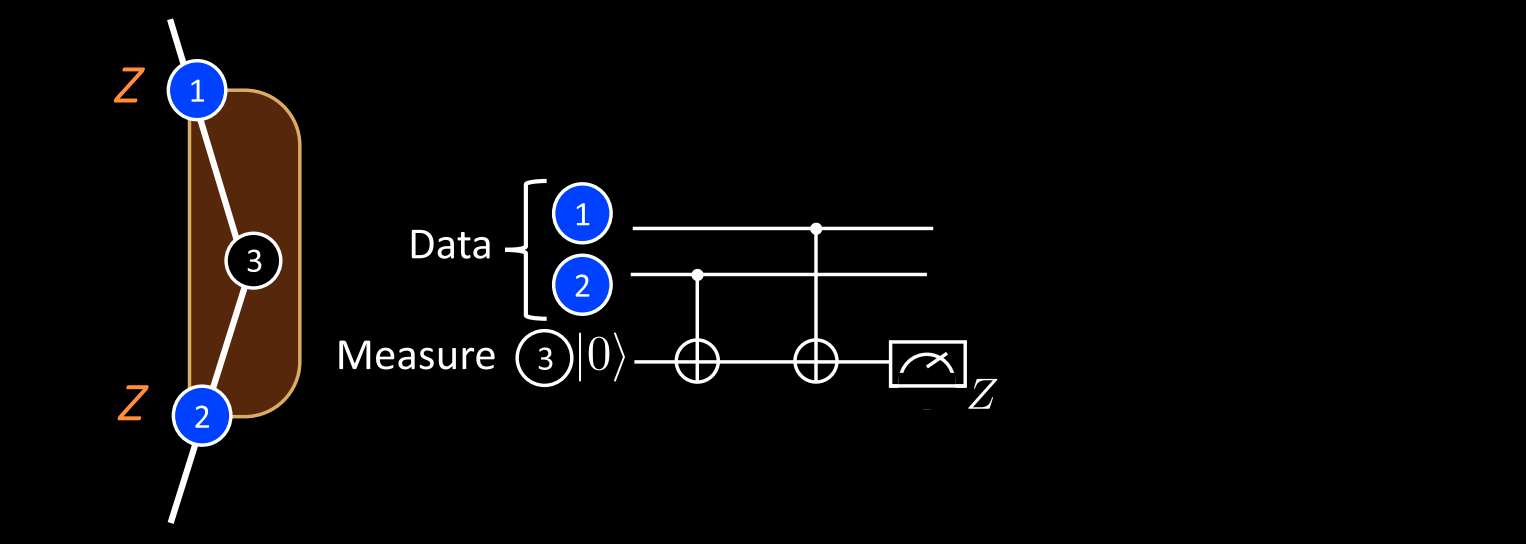

In [4]:
#qreg = QuantumRegister(7, 'q')
#creg = ClassicalRegister(2, 'c')
#qc = QuantumCircuit(qreg, creg)

def check_z(qc, creg):
    qc.reset([4, 5])
    qc.cx(2, 4)
    qc.cx(3, 4)
    qc.cx(0, 5)
    qc.cx(1, 5)
    qc.measure([4, 5], creg)
    qc.barrier()

#qc.draw(output='mpl', scale=scale_factor)

## Build Code State Circuit

$$
{\Large |\psi\rangle_{\rm code}} = \frac{1}{\sqrt{2}} \Large( |0000\rangle + |1111\rangle \Large)
$$

In [5]:
#qc = QuantumCircuit(qreg)

def code_state_init(qc):
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.barrier()

#qc.draw(output='mpl', scale=scale_factor)

## Put it all together

In [6]:
num_rounds = 2
qreg = QuantumRegister(7, 'q')
creg = ClassicalRegister(4 + 5*num_rounds, 'c') # 5 mid-circ meas per round

In [7]:
def check_rounds(qc, creg, num_rounds):
    for ridx in range(num_rounds):
        check_x(qc, creg[4 + 5*ridx: 7 + 5*ridx])
        check_z(qc, creg[7 + 5*ridx: 9 + 5*ridx])
        
    qc.measure(qreg[0:4], creg[0:4])

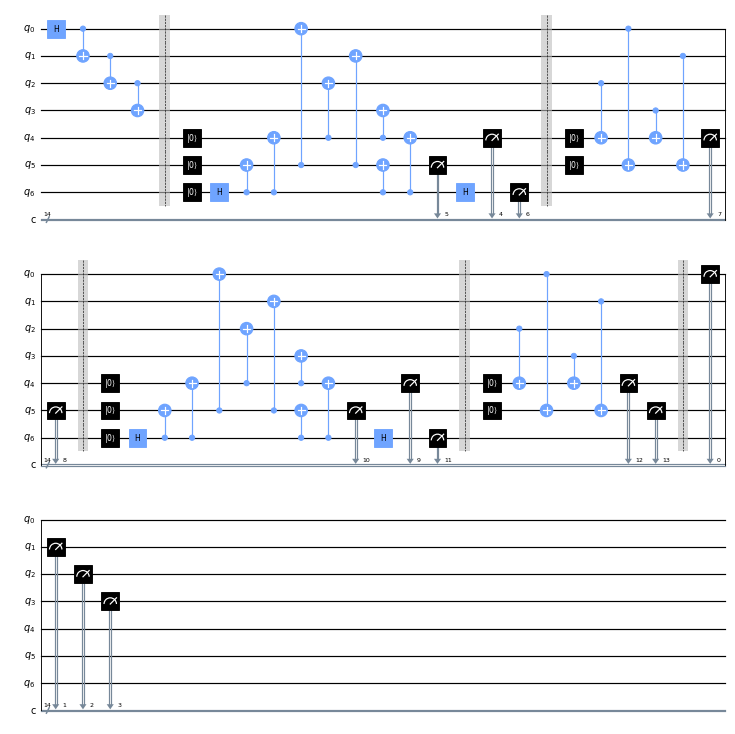

In [9]:
qc = QuantumCircuit(qreg, creg)
code_state_init(qc)
check_rounds(qc, creg, num_rounds)
qc.draw(output='mpl', scale=scale_factor)

## Run on Simulator

In [10]:
sim_shots = 10000
backend_sim = provider.get_backend('ibmq_qasm_simulator')
sim_job = backend_sim.run(qc, shots=sim_shots)
counts = sim_job.result().get_counts()

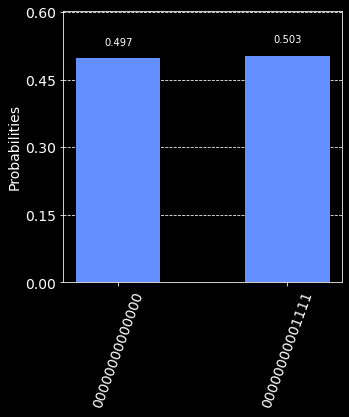

In [11]:
plot_histogram(counts, figsize=[5, 5])

# Run on Real Quantum Hardware

## Transpile X-parity Circuit (to get layout idea)

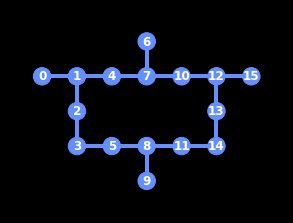

In [12]:
plot_gate_map(backend)

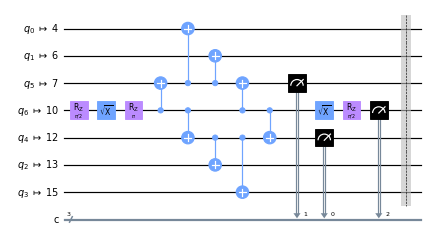

In [13]:
creg = ClassicalRegister(3, 'c')
qreg = QuantumRegister(7, 'q')
qc_x = QuantumCircuit(qreg, creg)
check_x(qc_x, creg)
qc_x_t = transpile(qc_x, backend, optimization_level=3) # stochastic mapper
qc_x_t.draw(output='mpl', idle_wires=False, scale=scale_factor)

In [14]:
print('Transpiled cx count is '+str(qc_x_t.count_ops()['cx'])+
      ', whereas abstract circuit has '+str(qc_x.count_ops()['cx']))

Transpiled cx count is 8, whereas abstract circuit has 8


In [15]:
initial_layout = [4, 6, 13, 15, 12, 7, 10]

## Transpile Z-parity and check for consistency

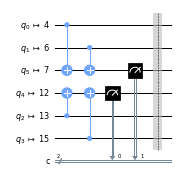

In [16]:
creg = ClassicalRegister(2, 'c')
qreg = QuantumRegister(7, 'q')
qc_z = QuantumCircuit(qreg, creg)
check_z(qc_z, creg)
qc_z_t = transpile(qc_z, backend, initial_layout=initial_layout) # use "optimized" layout
qc_z_t.draw(output='mpl', idle_wires=False, scale=0.5)

In [17]:
print('Transpiled cx count is '+str(qc_z_t.count_ops()['cx'])+
      ', whereas abstract circuit has '+str(qc_z.count_ops()['cx']))

Transpiled cx count is 4, whereas abstract circuit has 4


### Code State Initialization

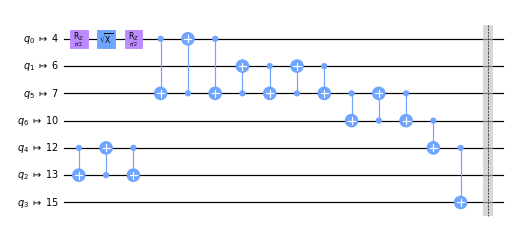

In [18]:
qc_init = QuantumCircuit(7)
code_state_init(qc_init)
qc_init_t = transpile(qc_init, backend, initial_layout=initial_layout) # use "optimized" layout
qc_init_t.draw(output='mpl', idle_wires=False, scale=scale_factor)

## Clever Trick: Generate 7-qubit Entanglement

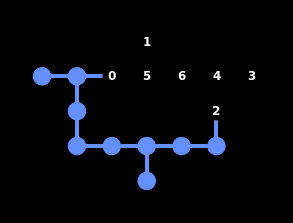

In [19]:
plot_circuit_layout(qc_init_t, backend)

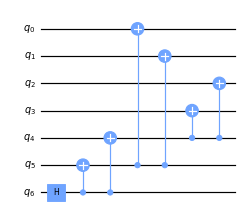

In [20]:
qc = QuantumCircuit(7)

qc.h(6)
qc.cx(6, 5)
qc.cx(6, 4)
qc.cx(5, 0)
qc.cx(5, 1)
qc.cx(4, 3)
qc.cx(4, 2)

qc.draw(output='mpl', scale=0.6)

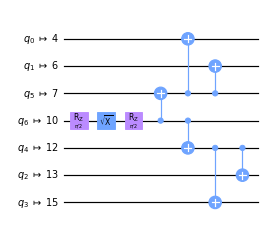

In [21]:
transpile(qc, backend, initial_layout=initial_layout).draw(output='mpl', idle_wires=False, scale=scale_factor)

### Now undo the unneeded entanglement

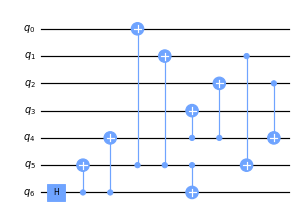

In [22]:
qc.cx(5, 6)
qc.cx(1, 5)
qc.cx(2, 4)

qc.draw(output='mpl', scale=0.6)

### Check this produces the same state

In [23]:
from qiskit.quantum_info import Statevector
sv1 = Statevector.from_instruction(qc_init)
sv2 = Statevector.from_instruction(qc)
sv1.equiv(sv2)

True

In [24]:
def code_state_init_heavy_hex(qc):
    qc.h(6)
    qc.cx(6, 5)
    qc.cx(6, 4)
    qc.cx(5, 0)
    qc.cx(5, 1)
    qc.cx(4, 3)
    qc.cx(4, 2)
    qc.cx(5, 6)
    qc.cx(1, 5)
    qc.cx(2, 4)
    qc.barrier()

## Put it all together now

In [25]:
num_rounds = 2
qreg = QuantumRegister(7, 'q')
creg = ClassicalRegister(4 + 5*num_rounds, 'c') # 5 mid-circ meas per round

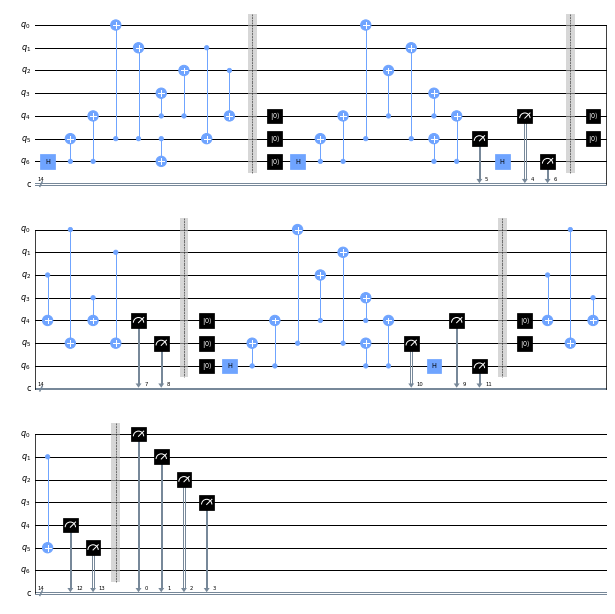

In [26]:
qc = QuantumCircuit(qreg, creg)
code_state_init_heavy_hex(qc)
check_rounds(qc, creg, num_rounds)
qc.draw(output='mpl', scale=0.5)

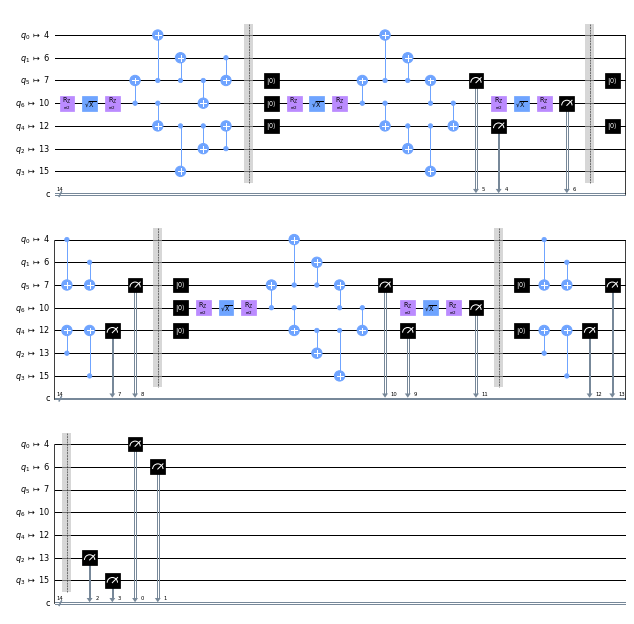

In [27]:
qc_t = transpile(qc, backend, initial_layout=initial_layout)
qc_t.draw(output='mpl', idle_wires=False, scale=0.5)

In [28]:
sim_shots = 10000
#backend_sim = provider.get_backend('ibmq_qasm_simulator')
backend_sim = AerSimulator.from_backend(FakeGuadalupe()) # noisy simulator backend
sim_job = backend_sim.run(qc, shots=sim_shots)
counts = sim_job.result().get_counts()

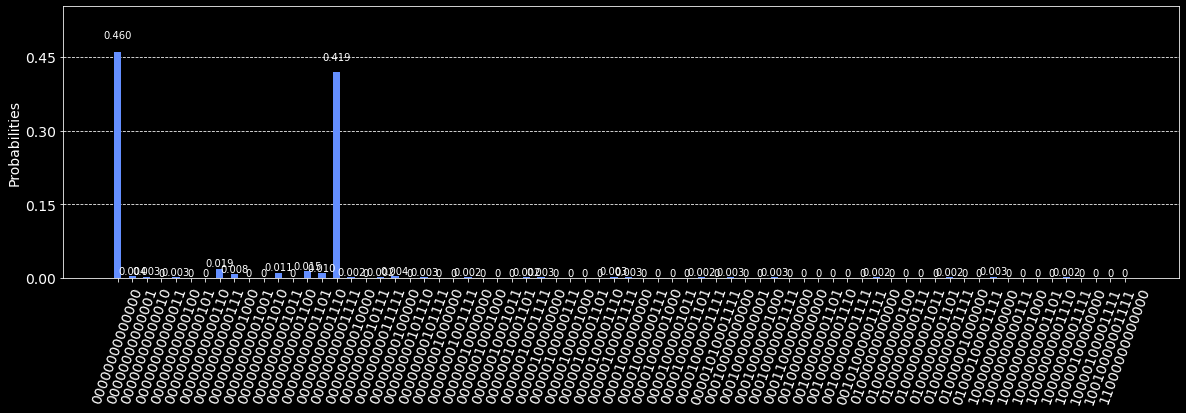

In [32]:
plot_histogram(counts, figsize=[20, 5])

In [29]:
# run on actual hardware
#import qiskit.tools.jupyter
#%qiskit_job_watcher

shots = 10000
#job = backend.run(qc_t, job_name='Heavy Hex Error Detection', shots=shots)

# or retrieve it
job = backend.retrieve_job('61aa9d246a8ec0f558199b50') # previously run

counts = job.result().get_counts()

In [30]:
error_counts = 0
for count in counts:
    logical_count = count[-4:] # registers 0-3 w/ data qubits
    
    # error occurs when logical_count is odd, multiplies by 1 when error occured
    error_counts += (logical_count.count('0') % 2)*counts[count]
    
print('(Raw) logical error rate is %2.1f%%' % (100*error_counts/shots))

(Raw) logical error rate is 41.4%


In [31]:
detected_shots = shots
det_error_counts = 0
for count in counts:
    if '1' in count[-7:-4] + count[-12:-9]: # x-error occured
        detected_shots -= counts[count]
    else:
        # add counts only if x-error did not occur
        logical_count = count[-4:]
        det_error_counts += (logical_count.count('0') % 2)*counts[count]
        
print('(Raw) logical error rate less errors detected is %2.1f%%' % (100*det_error_counts/detected_shots))

(Raw) logical error rate less errors detected is 38.1%


In [32]:
print('Percent of shots with no error %2.1f%%' % (100*detected_shots/shots))

Percent of shots with no error 20.6%


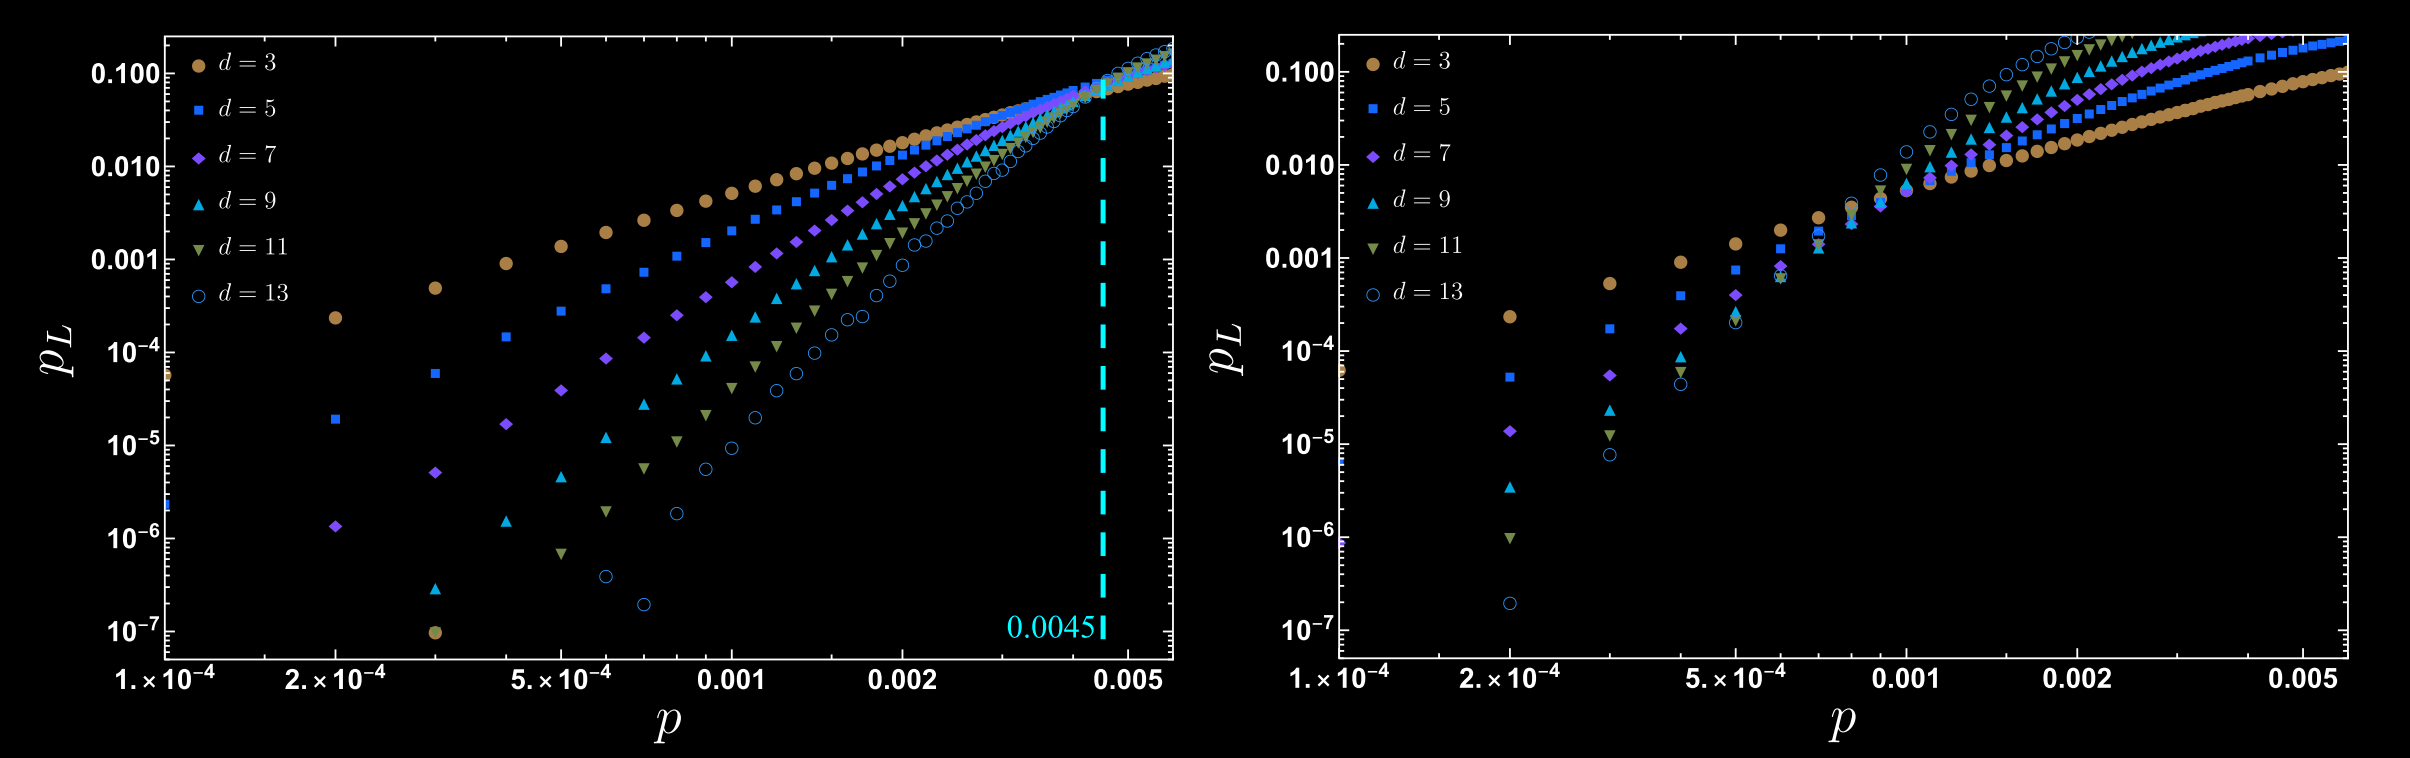

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table